# Student_Feature_Selection

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from itertools import chain

### Download data

In [18]:
dat = pd.read_csv('https://raw.githubusercontent.com/TeddTech/Student_Performance/master/data/marks_data.csv')

In [19]:
dat.head()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,GP,F,18,U,GT3,A,4,4,at_home,...,4,3,4,1,1,3,6,5,6,6
1,2,GP,F,17,U,GT3,T,1,1,at_home,...,5,3,3,1,1,3,4,5,5,6
2,3,GP,F,15,U,LE3,T,1,1,at_home,...,4,3,2,2,3,3,10,7,8,10
3,4,GP,F,15,U,GT3,T,4,2,health,...,3,2,2,1,1,5,2,15,14,15
4,5,GP,F,16,U,GT3,T,3,3,other,...,4,3,2,1,2,5,4,6,10,10


### data cleaning and wrangling

In [20]:
dat = dat.drop(['Unnamed: 0'], axis=1)

In [23]:
np.max(dat[['G1','G2','G3']])

G1    19
G2    19
G3    20
dtype: int64

In [26]:
dat[['G1','G2','G3']] = dat[['G1','G2','G3']]/20

In [31]:
dat[['G1','G2','G3']].head()

,G1,G2,G3
0,0.25,0.30,0.30
1,0.25,0.25,0.30
2,0.35,0.40,0.50
3,0.75,0.70,0.75
4,0.30,0.50,0.50


In [39]:
dat['G'] =  dat[['G1', 'G2', 'G3']].sum(axis=1)
dat[['G']] = dat[['G']]/3
dat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,0.25,0.30,0.30,0.283333
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,0.25,0.25,0.30,0.266667
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,0.35,0.40,0.50,0.416667
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,0.75,0.70,0.75,0.733333
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,0.30,0.50,0.50,0.433333


In [159]:
# function used from the followin stackoverflow thread: https://stackoverflow.com/questions/46761978/factorize-values-across-dataframe-columns-with-consistent-mappings

def Fact(data, columns):
    data[[columns]] = data[[columns]].apply(lambda x: pd.factorize(x)[0])
    return data[[columns]]

# Factorized columns that are strings

for i in list(dat):
    
    if type(dat[[i]].iloc[0,0]) == str:
        dat[[i]] = Fact(dat, i )
        
dat.G[dat.G >= 0.5] = 1 
dat.G[dat.G < 0.5] = 0

### EDA 

In [41]:
dat.describe(include='all')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G
count,395,395,395.000000,395,395,395,395.000000,395.000000,395,395,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,349,208,NaN,307,281,354,NaN,NaN,141,217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.696203,NaN,NaN,NaN,2.749367,2.521519,NaN,NaN,...,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,0.545443,0.535696,0.520759,0.533966
std,NaN,NaN,1.276043,NaN,NaN,NaN,1.094735,1.088201,NaN,NaN,...,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,0.165960,0.188075,0.229072,0.184839
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.150000,0.000000,0.000000,0.066667
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,...,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.400000,0.450000,0.400000,0.416667
50%,NaN,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,...,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,0.550000,0.550000,0.550000,0.533333
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,...,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,0.650000,0.650000,0.700000,0.666667


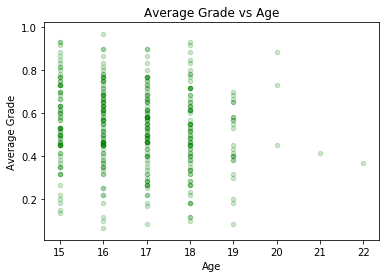

In [49]:
dat.plot(x='age', y='G', kind='scatter', alpha=0.2, c='green')
plt.xlabel("Age")
plt.ylabel("Average Grade")
plt.title('Average Grade vs Age')
plt.show()

In [88]:
type(dat.iloc[:,2])

pandas.core.series.Series

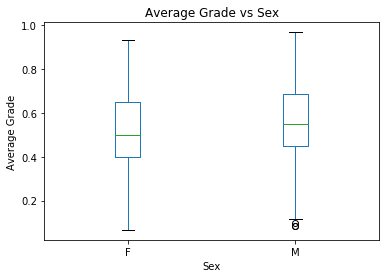

In [89]:
dat_pivot = dat.pivot(columns="sex", values="G")
dat_pivot.plot.box()
plt.xlabel("Sex")
plt.ylabel("Average Grade")
plt.title('Average Grade vs Sex')
plt.show()

### Feature and Model Selectiond

In [185]:
X = dat.iloc[:,0:30]
y = dat.iloc[:,33]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30)

In [265]:
model2 = LogisticRegression()
model2.fit(X,y)
print('Validation score for L2 in logistic regression is', model2.score(Xtest, ytest))
print('Number of features selected by L2 in logistic regression is', np.sum(np.absolute(model2.coef_)>10e-6))


model1 = LogisticRegression(penalty='l1')
model1.fit(X,y)
print('\nValidation score for L1 in logistic regression is', model1.score(Xtest, ytest))
print('Number of features selected by L1 in logistic regression is', np.sum(np.absolute(model1.coef_)>10e-6))
print('Features that were not selected for are:')
c = model1.coef_
f = np.array(np.matrix(np.argwhere(c==0))[:,1])
f = list(chain.from_iterable(f))
for i in f:
    print(list(dat)[i])

model2 = LinearSVC()
model2.fit(X,y)
print('\nValidation score for L2 in LinearSVC is', model2.score(Xtest, ytest))
print('Number of features selected by L2 in LinearSVC is', np.sum(np.absolute(model2.coef_)>10e-6))


model1 = LinearSVC(penalty='l1', dual=False)
model1.fit(X,y)
print('\nValidation score for L1 in LinearSVC is', model1.score(Xtest, ytest))
print('Number of features selected by L1 in LinearSVC is', np.sum(np.absolute(model1.coef_)>10e-6))
print('Features that were not selected for are:')
c = model1.coef_
f = np.array(np.matrix(np.argwhere(c==0))[:,1])
f = list(chain.from_iterable(f))
for i in f:
    print(list(dat)[i])

Validation score for L2 in logistic regression is 0.731092436975
Number of features selected by L2 in logistic regression is 30

Validation score for L1 in logistic regression is 0.739495798319
Number of features selected by L1 in logistic regression is 27
Features that were not selected for are:
school
paid
Dalc

Validation score for L2 in LinearSVC is 0.72268907563
Number of features selected by L2 in LinearSVC is 30

Validation score for L1 in LinearSVC is 0.731092436975
Number of features selected by L1 in LinearSVC is 29
Features that were not selected for are:
paid



| Model | Validaiton Score |
|--------------------|------------|
| Logistic Regression (L2) | 0.73 |
| Logistic Regression (L1) | 0.74 | 
| Linear SVC (L2) | 0.72 |    
| Linear SVC (L1) | 0.73 |   
| Decision Tree  | 0.67 |   
| KNN | 0.61 |  
| SVC | 0.69 |

| Model | Validaiton Score | Number of features | Excluded Features |
|--------------------|------------|------|------------|
| Logistic Regression (L2) | 0.73 |  30 |  None |
| Logistic Regression (L1) | 0.74 |  27 | shcool, paid, Dalc |
| Linear SVC (L2) | 0.72 |  30 | None |
| Linear SVC (L1) | 0.73 |  28  | paid |

In [194]:
split = ShuffleSplit(n_splits=3, test_size=0.5) 
mod = DecisionTreeClassifier()
parameters2 = {'max_depth': list(range(1,50))}

model2 = GridSearchCV(mod, parameters2, cv=split)
model2.fit(X, y)

print(model2.best_params_)
print(model2.best_score_)

{'max_depth': 2}
0.66835016835


In [197]:
split = ShuffleSplit(n_splits=3, test_size=0.5) 
mod = KNeighborsClassifier()
parameters2 = {'n_neighbors': list(range(1,80))}

model2 = GridSearchCV(mod, parameters2, cv=split)
model2.fit(X, y)

print(model2.best_params_)
print(model2.best_score_)

{'n_neighbors': 44}
0.606060606061


In [198]:
split = ShuffleSplit(n_splits=3, test_size=0.5) 
mod = SVC()
parameters2 = {'gamma':[10**-5,10**-4,10**-3,10**-2,10**-1,1,10**-2,10**-3,10**-4,10**-5],
               'C':[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e1,1e2,1e3,1e4,1e5,1e6]}

model2 = GridSearchCV(mod, parameters2, cv=split)
model2.fit(X, y)

print(model2.best_params_)
print(model2.best_score_)

{'C': 10000.0, 'gamma': 1e-05}
0.686868686869


Logistic Regression has the best performance

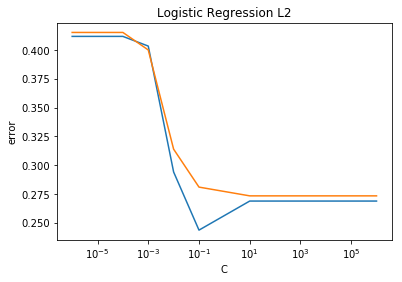

Training error: 27.3417721519 with C at 10.0
Validation error: 24.3697478992 with C at 0.1


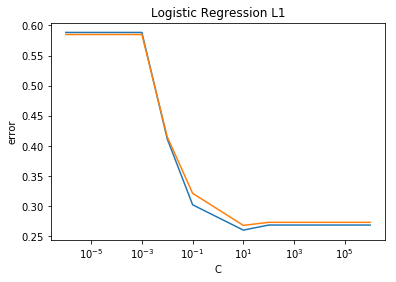

Training error: 26.835443038 with C at 10.0
Validation error: 26.0504201681 with C at 10.0


In [278]:
C = []
v = []
t=[]

for c in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e1,1e2,1e3,1e4,1e5,1e6]:
    model = LogisticRegression(C=c)
    model.fit(X, y)
    yhat = model.score(Xtest, ytest)
    mu = model.score(X, y)

    C.append(c)
    v.append(1-yhat)
    t.append(1-mu)

plt.plot(C, v)
plt.plot(C, t) #train
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('error')
plt.title("Logistic Regression L2")
plt.show()
print("Training error:", np.min(t)*100, 'with C at', C[np.argmin(t)])
print("Validation error:",np.min(v)*100, 'with C at', C[np.argmin(v)])

C = []
v = []
t=[]

for c in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e1,1e2,1e3,1e4,1e5,1e6]:
    model = LogisticRegression(C=c, penalty='l1')
    model.fit(X, y)
    yhat = model.score(Xtest, ytest)
    mu = model.score(X, y)

    C.append(c)
    v.append(1-yhat)
    t.append(1-mu)

plt.plot(C, v)
plt.plot(C, t) #train
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('error')
plt.title("Logistic Regression L1")
plt.show()
print("Training error:", np.min(t)*100, 'with C at', C[np.argmin(t)])
print("Validation error:",np.min(v)*100, 'with C at', C[np.argmin(v)])

In [277]:
model2 = LogisticRegression(C=0.1)
model2.fit(X,y)
print('Validation score for L2 in logistic regression is', model2.score(Xtest, ytest))
print('Number of features selected by L2 in logistic regression is', np.sum(np.absolute(model2.coef_)>10e-6))


model1 = LogisticRegression(penalty='l1', C=10)
model1.fit(X,y)
print('\nValidation score for L1 in logistic regression is', model1.score(Xtest, ytest))
print('Number of features selected by L1 in logistic regression is', np.sum(np.absolute(model1.coef_)>10e-6))
print('Features that were not selected for are:')
c = model1.coef_
f = np.array(np.matrix(np.argwhere(c==0))[:,1])
f = list(chain.from_iterable(f))
for i in f:
    print(list(dat)[i])

Validation score for L2 in logistic regression is 0.756302521008
Number of features selected by L2 in logistic regression is 30

Validation score for L1 in logistic regression is 0.739495798319
Number of features selected by L1 in logistic regression is 29
Features that were not selected for are:
paid


After adjusting the hyperparameter C for both L2 and L1 logistic regression, at optimal value for C for L2 it out perfroms the optimal value for C at L1.

In conclusion, A logistic regression model should be chosen with all features included with a C values at 0.1 using L2 regularization to predict whether students passed.